In [1]:
!pip install neuromancer

In [2]:
import torch
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.plot import pltCL, pltPhase
import matplotlib.pyplot as plt
import casadi as ca

In [3]:
# Double integrator parameters
nx = 2
nu = 2
A = torch.tensor([[1.2, 1.0],
                  [0.0, 1.0]])
B = torch.tensor([[1.0, 1.0],
                  [0.5, 0.5]])

# linear state space model
xnext = lambda x, u: x @ A.T + u @ B.T
# Create a Node for the system dynamics
MIMO_system = Node(xnext, ['X', 'U'], ['X'], name='MIMO system')

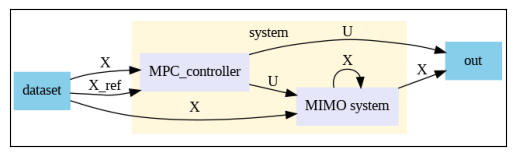


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [4]:
# Define the MPC implementation
def mpc_implement(x0, x_ref):
    x0 = x0.numpy().reshape(nx, 1)
    x_ref = x_ref.numpy().reshape(nx, 1)

    Q = ca.DM([[100.0, 0.0], [0.0, 100.0]])
    R = ca.DM([[1.0, 0.0], [0.0, 1.0]])

    u_min = -10.0, -10.0
    u_max = 10.0, 10.0
    x_min = -10.0, -10.0
    x_max = 10.0, 10.0
    mpc_horizon = 10

    # Create optimization problem
    opti = ca.Opti()
    X = opti.variable(nx, mpc_horizon + 1)
    U = opti.variable(nu, mpc_horizon)

    # Initial state constraint
    opti.subject_to(X[:, 0] == x0)

    # Objective function
    cost_func = 0
    for k in range(mpc_horizon):
        x_k = X[:, k]
        u_k = U[:, k]
        x_next_k = X[:, k+1]
        cost_func += ca.mtimes([(x_k - x_ref).T, Q, (x_k - x_ref)]) + ca.mtimes([u_k.T, R, u_k])
        opti.subject_to(x_next_k == ca.mtimes(A.numpy(), x_k) + ca.mtimes(B.numpy(), u_k))
        opti.subject_to(u_min <= u_k)
        opti.subject_to(u_k <= u_max)
        opti.subject_to(x_min <= x_k)
        opti.subject_to(x_k <= x_max)

    cost_func += ca.mtimes([(X[:, -1] - x_ref).T, Q, (X[:, -1] - x_ref)])
    opti.minimize(cost_func)
    solver_opts = {'ipopt': {'print_level': 0, 'max_iter': 1000}, 'print_time': 0}
    opti.solver('ipopt', solver_opts)
    sol = opti.solve()
    U_opt = sol.value(U)
    output = torch.tensor(U_opt[:, 0], dtype=torch.float32).view(1, -1)
    # print(output)
    return output

mpc_node = Node(mpc_implement, ['X', 'X_ref'], ['U'], name='MPC_controller')
cl_system = System([mpc_node, MIMO_system])
cl_system.show()

nsteps = 50
cl_system.nsteps = nsteps

data = {
    'X': torch.ones(1, 1, nx, dtype=torch.float32),
    'X_ref': torch.zeros(1, nsteps, nx, dtype=torch.float32)
}

trajectories = cl_system(data)


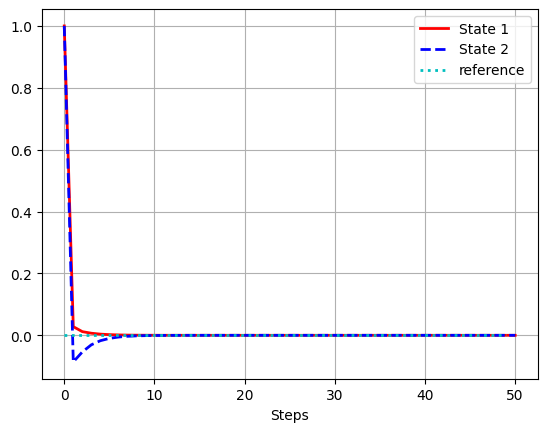

In [23]:
import matplotlib.pyplot as plt
plt.plot(trajectories['X'].detach().numpy()[0, :, 0], label="State 1", color ="r", linewidth = 2)
plt.plot(trajectories['X'].detach().numpy()[0, :, 1], label="State 2", color ="b", linestyle='--', linewidth = 2)
plt.plot(trajectories['X_ref'].detach().numpy()[0, :, 1], label="reference", color = "c", linestyle=':', linewidth = 2)
plt.grid()
plt.xlabel("Steps")
plt.legend()
plt.show()